In [ ]:
if'google.colab' in str(get_ipython()):
    %pip install psifr

# PrototypeCMR

The Context Maintenance and Retrieval (CMR) as specified by Morton and Polyn (2016) takes the form of a simplified neural network with two interacting representations, a feature-based representation of the studied item and a contextual representation (the context layer, $C$). The two layers communicate with one another through two sets of associative connections represented by matrices $M^{FC}$ and $M^{CF}$. Each of these weight matrices contains both pre-experimental associations and new associations learned during the experiment.

In [3]:
# export
# hide

import numpy as np
import math
from numba import float64, int32, boolean
from numba.experimental import jitclass

cmr_spec = [
    ('item_count', int32), 
    ('encoding_drift_rate', float64),
    ('start_drift_rate', float64),
    ('recall_drift_rate', float64),
    ('shared_support', float64),
    ('item_support', float64),
    ('learning_rate', float64),
    ('primacy_scale', float64),
    ('primacy_decay', float64),
    ('stop_probability_scale', float64),
    ('stop_probability_growth', float64),
    ('choice_sensitivity', float64),
    ('context', float64[::1]),
    ('preretrieval_context', float64[::1]),
    ('recall', float64[::1]),
    ('retrieving', boolean),
    ('recall_total', int32),
    ('primacy_weighting', float64[::1]),
    ('probabilities', float64[::1]),
    ('mfc', float64[:,::1]),
    ('mcf', float64[:,::1]),
    ('encoding_index', int32),
    ('items', float64[:,::1]),
    ('sampling_rule', int32)
]

In [27]:
# export

#@jitclass(cmr_spec)
class CMR:

    def __init__(self, item_count, presentation_count, encoding_drift_rate, start_drift_rate, recall_drift_rate, 
                 shared_support, item_support, learning_rate, primacy_scale, primacy_decay, stop_probability_scale,
                 stop_probability_growth, choice_sensitivity, sampling_rule):
        
        # store initial parameters
        self.item_count = item_count
        self.encoding_drift_rate = encoding_drift_rate
        self.start_drift_rate = start_drift_rate
        self.recall_drift_rate = recall_drift_rate
        self.shared_support = shared_support
        self.item_support = item_support
        self.learning_rate = learning_rate
        self.primacy_scale = primacy_scale
        self.primacy_decay = primacy_decay
        self.stop_probability_scale = stop_probability_scale
        self.stop_probability_growth = stop_probability_growth
        self.choice_sensitivity = choice_sensitivity
        self.sampling_rule = sampling_rule
        
        # at the start of the list context is initialized with a state orthogonal to the pre-experimental context
        # associated with the set of items
        self.context = np.zeros(item_count + 1)
        self.context[0] = 1
        self.preretrieval_context = self.context
        self.recall = np.zeros(item_count) # recalls has at most `item_count` entries
        self.retrieving = False
        self.recall_total = 0

        # predefine primacy weighting vectors
        self.primacy_weighting = primacy_scale * np.exp(-primacy_decay * np.arange(presentation_count)) + 1

        # preallocate for outcome_probabilities
        self.probabilities = np.zeros((item_count + 1))

        # The two layers communicate with one another through two sets of associative connections represented by
        # matrices Mfc and Mcf. Pre-experimental Mfc is 1-learning_rate and pre-experimental Mcf is item_support for 
        # i=j. For i!=j, Mcf is shared_support.
        self.mfc = np.eye(item_count, item_count+1, 1) * (1 - learning_rate)
        self.mcf = np.ones((item_count, item_count)) * shared_support
        for i in range(item_count):
            self.mcf[i, i] = item_support
        self.mcf =  np.vstack((np.zeros((1, item_count)), self.mcf))
        self.encoding_index = 0
        self.items = np.eye(item_count, item_count)

    def experience(self, experiences):
        
        for i in range(len(experiences)):
            self.update_context(self.encoding_drift_rate, experiences[i])
            self.mfc += self.learning_rate * np.outer(self.context, experiences[i]).T
            self.mcf += self.primacy_weighting[self.encoding_index] * np.outer(self.context, experiences[i])
            self.encoding_index += 1
            
    def update_context(self, drift_rate, experience=None):

        # first pre-experimental or initial context is retrieved
        if experience is not None:
            context_input = np.dot(experience, self.mfc)
            context_input = context_input / np.sqrt(np.sum(np.square(context_input))) # norm to length 1
        else:
            context_input = np.zeros((self.item_count+1))
            context_input[0] = 1

        # updated context is sum of context and input, modulated by rho to have len 1 and some drift_rate
        rho = np.sqrt(1 + np.square(drift_rate) * (np.square(self.context * context_input) - 1)) - (
            drift_rate * (self.context * context_input))
        self.context = (rho * self.context) + (drift_rate * context_input)

    def activations(self, probe, use_mfc=False):

        if use_mfc:
            return np.dot(probe, self.mfc) + 10e-7
        else:
            return np.dot(probe, self.mcf) + 10e-7
        
    def outcome_probabilities(self, activation_cue):

        activation = self.activations(activation_cue)
        if self.sampling_rule == 0:
            activation = np.power(activation, self.choice_sensitivity)
        else:
            activation = np.exp((2 * activation)/ self.choice_sensitivity)

        self.probabilities = np.zeros((self.item_count + 1))
        self.probabilities[0] = min(self.stop_probability_scale * np.exp(
            self.recall_total * self.stop_probability_growth), 1.0  - (
                (self.item_count-self.recall_total) * 10e-7))

        for already_recalled_item in self.recall[:self.recall_total]:
            activation[int(already_recalled_item)] = 0
        if np.sum(activation==np.inf) > 0:
            activation[activation==np.inf] = 1.7976931348623157e+308/np.sum(activation==np.inf) - np.sum(activation[np.logical_not(activation==np.inf)])
        self.probabilities[1:] = (1-self.probabilities[0]) * activation / np.sum(activation)

        return self.probabilities

    def free_recall(self, steps=None):

        # some amount of the pre-list context is reinstated before initiating recall
        if not self.retrieving:
            self.recall = np.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True

        # number of items to retrieve is # of items left to recall if steps is unspecified
        if steps is None:
            steps = self.item_count - self.recall_total
        steps = self.recall_total + steps
        
        # at each recall attempt
        while self.recall_total < steps:

            # the current state of context is used as a retrieval cue to attempt recall of a studied item
            # compute outcome probabilities and make choice based on distribution
            outcome_probabilities = self.outcome_probabilities(self.context)
            if np.any(outcome_probabilities[1:]):
                choice = np.sum(np.cumsum(outcome_probabilities) < np.random.rand())
            else:
                choice = 0

            # resolve and maybe store outcome
            # we stop recall if no choice is made (0)
            if choice == 0:
                self.retrieving = False
                self.context = self.preretrieval_context
                break
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        return self.recall[:self.recall_total]

    def force_recall(self, choice=None):

        if not self.retrieving:
            self.recall = np.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True

        if choice is None:
            pass
        elif choice > 0:
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        else:
            self.retrieving = False
            self.context = self.preretrieval_context
        return self.recall[:self.recall_total]

# Demo
To play with the model, set parameters below and run the cell.

Since we use a just-in-time compiler to speed up execution, the time to first figure will be longer than successive executions.

In [30]:
import pandas as pd
from psifr import fr
import matplotlib.pyplot as plt


def temporal_organization_analyses(model, experiment_count, savefig=False, figsize=(15, 15), first_recall_item=None):
    """
    Visualization of the outcomes of a trio of organizational analyses of model performance on a free recall
    task.

    **Required model attributes**:
    - item_count: specifies number of items encoded into memory  
    - context: vector representing an internal contextual state  
    - experience: adding a new trace to the memory model  
    - free_recall: function that freely recalls a given number of items or until recall stops  

    **Other arguments**:  
    - experiment_count: number of simulations to compute curves over  
    - savefig: whether to save or display the figure of interest

    **Returns** three plots corresponding to the contents of Figure 4 in Morton & Polyn, 2016:  
    1. Recall probability as a function of serial position  
    2. Probability of starting recall with each serial position  
    3. Conditional response probability as a function of lag  
    """
    
    # encode items
    try:
        model.experience(np.eye(model.item_count, model.item_count + 1, 1))
    except ValueError:
        # so we can apply to CMR
        model.experience(np.eye(model.item_count, model.item_count))
        
    # simulate retrieval for the specified number of times, tracking results in df
    data = []
    for experiment in range(experiment_count):
        data += [[experiment, 0, 'study', i + 1, i] for i in range(model.item_count)]
    for experiment in range(experiment_count):
        if first_recall_item is not None:
            model.force_recall(first_recall_item)
        data += [[experiment, 0, 'recall', i + 1, o] for i, o in enumerate(model.free_recall())]
    data = pd.DataFrame(data, columns=['subject', 'list', 'trial_type', 'position', 'item'])
    merged = fr.merge_free_recall(data)
    
    # visualizations
    # spc
    recall = fr.spc(merged)
    g = fr.plot_spc(recall)
    plt.title('Serial Position Curve')
    if savefig:
        plt.savefig('figures/spc.jpeg', bbox_inches='tight')
    else:
        plt.show()

    # P(Start Recall) For Each Serial Position
    prob = fr.pnr(merged)
    pfr = prob.query('output <= 1')
    g = fr.plot_spc(pfr).add_legend()
    plt.title('Probability of Starting Recall With Each Serial Position')
    if savefig:
        plt.savefig('figures/pfr.jpeg', bbox_inches='tight')
    else:
        plt.show()

    # Conditional response probability as a function of lag
    crp = fr.lag_crp(merged)
    g = fr.plot_lag_crp(crp)
    plt.title('Conditional Response Probability')
    if savefig:
        plt.savefig('figures/crp.jpeg', bbox_inches='tight')
    else:
        plt.show()

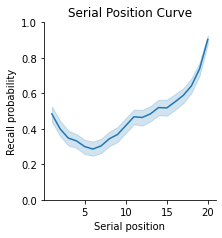

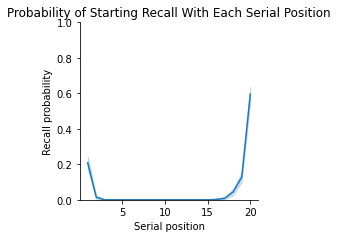

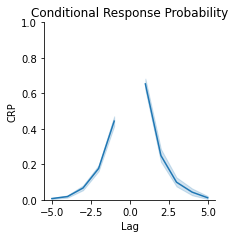

In [31]:
parameters = {
    'item_count': 20,
    'presentation_count': 20,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 3,
    'sampling_rule': 0
}

experiment_count = 500

model = CMR(**parameters)
temporal_organization_analyses(model, experiment_count)